Number of Quantization Levels in the original audio:  9942
Number of bits:  14


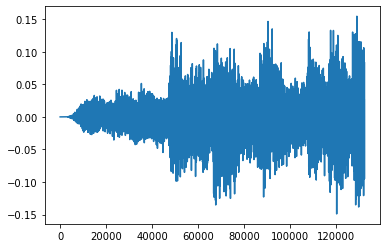

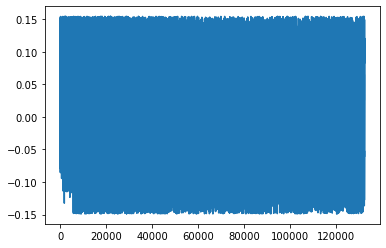

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import wavio

x, Fs = sf.read('sound.wav')

x = x[: int(len(x) / 20)]
sd.play(x, Fs)


def levelsOfQuantization(x):
    unique_data = np.unique(x)
    unique_data = np.sort(unique_data)
    min_step_size = float('inf')
    for i in range(1, len(unique_data)):
        if min_step_size > unique_data[i] - unique_data[i-1]:
            min_step_size = unique_data[i] - unique_data[i-1]
    maxu = max(unique_data)
    minu = min(unique_data)
    return int(np.ceil((maxu - minu) / min_step_size))


num_of_levels = levelsOfQuantization(x)
bits = int(np.ceil(np.log2(num_of_levels)))
print('Number of Quantization Levels in the original audio: ', num_of_levels)
print('Number of bits: ', bits)

# to find bit stream for each n every sample of x
minu, maxu = min(x), max(x)
bit_seqs = ''
for d in x:
    SAMPLE = ''
    tmin, tmax = minu, maxu
    for _ in range(bits):
        mid = (tmin + tmax) / 2
        if d > mid:
            SAMPLE += '1'
            tmin = mid
        else:
            SAMPLE += '0'
            tmax = mid
    bit_seqs += SAMPLE + ' '
    # bit_seqs+='{0:b} '.format(d)
bit_seqs = bit_seqs.split()


def generate_signal(bit_seqs):
    sig = []
    when_1 = [A] * 10
    when_0 = [-1 * A] * 10

    for bit_seq in bit_seqs:
        for b in bit_seq:
            if b == '1':
                sig.extend(when_1)
            else:
                sig.extend(when_0)
    return sig


def match_filter(r_n, A=10, n=10):
    """
    Takes
    r_n: Receiving Signal
    A: Ampitude of s1(t) and s2(t)
    n: number of bits

    returns
    Detected Signal
    """
    a1, a2 = A, -A
    threshold = (a1 + a2) / 2
    h = []  # h(t)=s1(t)-s2(t) 0<=t<=T
    j = 0.0
    while j < T:
        h.append(a1-a2)
        j += T / 10
    # print(h)
    detected_msg = ''
    for i in range(n):
        # print(r_n[i*10:(i+1)*10])
        z = sum(np.convolve(r_n[i*10:(i+1)*10], h))
        if z > threshold:
            detected_msg += '1'
        else:
            detected_msg += '0'

        if (i + 1) % bits == 0:
            detected_msg += ' '
    return detected_msg


def detection(received_data):
    detected = []
    for bit_seq in received_data:
        dec, power = 0, 1
        for i in range(bits - 1, -1, -1):
            if bit_seq[i] == '1':
                dec += power
            power = power * 2
        detected.append(all_data[dec])
    return detected


n = len(x) * bits
A, T, Ts, sigma = 10, 1, 0.1, 20
sig = generate_signal(bit_seqs)
t = np.arange(0, n * T, Ts)
noise = sigma*np.random.randn(n*10)
received_data = match_filter(sig + noise, A, n)
received_data = received_data.split()

all_data = np.linspace(minu, maxu, 2**bits)

final_x = detection(received_data)

plt.figure(1)
plt.plot(x)
plt.figure(2)
plt.plot(final_x)
plt.show()

final_x = np.array(final_x)
wavio.write("output.wav", final_x, Fs, sampwidth=3)

filtered_music, Fs = sf.read('output.wav')
sd.play(filtered_music, Fs)
